# AMIA 2016 Annual Symposium Workshop (WG13)

### Mining Large-scale Cancer Genomics Data Using Cloud-based Bioinformatics Approaches (RNAseq)
### * Part 03 Hands-on practice on how to associate gene expression with clincial data

Riyue Bao, Ph.D. 
Center for Research Informatics,
The University of Chicago.
November 13, 2016

***

The workshop materials are accessible on [Github](https://github.com/cribioinfo/CRI-Workshop-AMIA-2016-RNAseq).

## Table of Contents: <a class="anchor" id="top"></a>
* [Objective](#01)
* [Workflow](#02)
* [Dataset](#03)
* [How to associate gene expression with clincial outcome](#04)
	* [1. Clean the environment](#04.1)
	* [2. Start the clock!](#04.2)
	* [3. Load libraries / packages](#04.3)
	* [4. Set up global parameters, input/output directories and files](#04.4)
	* [5. Print analysis info](#04.5)
	* [6. Import data files](#04.6)
	* [7. Preprocess data: Clinical and Expression data](#04.7)
	* [8. Cluster patients based on expression profiles (NMF)](#04.8)
	* [9. Plot sample correlation & gene expression heatmap after clustering](#04.9)
	* [10. Survival analysis: KM plot and log-rank test](#04.10)
	* [11. Survival analysis: Cox multi- and univariant model](#04.11)
	* [12. Stop the clock!](#04.12)

***

## Objective<a class="anchor" id="01"></a> <small>[[top](#top)]</small>

* Learn the background and application of The Cancer Genome Atlas (TCGA)
* Learn the structure and access of Genomics Data Commons (GDC)
* Explore datasets hosted on GDC
* Practice how to associate gene expression with clincial data

***

## Workflow<a class="anchor" id="02"></a> <small>[[top](#top)]</small>

The analysis takes 3 major steps.

<img src='ipynb_data/assets/Figure26.png', title = 'TCGA & Clinical workflow', width = 900, height = 900>

***

## Dataset<a class="anchor" id="03"></a> <small>[[top](#top)]</small>

The Cancer Genome Atlas, Ovrian Cancer (TCGA-OV), miRNA gene expression and Clinical data.

<blockquote>
The Cancer Genome Atlas Research Network. 2011. [Integrated genomic analyses of ovarian carcinoma](http://www.nature.com/nature/journal/v474/n7353/full/nature10166.html). Nature 474, 609–615)
</blockquote>

***

## Genomic Data Commons (GDC)
    
* Website: https://gdc-portal.nci.nih.gov
* Hosts large-scale multiomics & clinical data (TCGA, TARGET, etc.)
* Powerful GUI for interactive exploration & visualization
* Data access and download
    * [gdc-client](https://gdc.cancer.gov/access-data/gdc-data-transfer-tool)
    * [GDC API tools](https://gdc.cancer.gov/developers/gdc-application-programming-interface-api)
    * [Website download](https://gdc-portal.nci.nih.gov/search/s?facetTab=cases)
    * [TCGAbiolinks](https://bioconductor.org/packages/release/bioc/html/TCGAbiolinks.html) *v2.2.5 or above* (require `R 3.3` or above)

<img src='ipynb_data/assets/Figure23.2.png', title = 'GDC', width = 600, height = 600>

***

## How to associate gene expression with clincial outcome<a class="anchor" id="04"></a> <small>[[top](#top)]</small>

Commonly used tool / package for survival include `survival`.

In this workshop, We will demo how to use `survival` to identify if PRDM11 gene expression is a prognosis factor of DLBC.

***

### 1. Clean the environment<a class="anchor" id="04.1"></a> <small>[[top](#top)]</small>

In [1]:
rm(list=ls())
set.seed(13)

### 2. Start the clock!<a class="anchor" id="04.2"></a> <small>[[top](#top)]</small>

In [2]:
ptm <- proc.time()

### 3. Load libraries / packages<a class="anchor" id="04.3"></a> <small>[[top](#top)]</small>

In [3]:
##-- Those packages were pre-installed in the AWS machine
pkg.list <- c('ggplot2', 'RColorBrewer', 'reshape', 'broom',
             'gplots', 'survival', 'NMF', 'IRdisplay')
for(pkg in pkg.list) {
    print(pkg)
    suppressMessages(library(pkg, character.only = TRUE))
}

[1] "ggplot2"
[1] "RColorBrewer"
[1] "reshape"
[1] "broom"
[1] "gplots"
[1] "survival"
[1] "NMF"
[1] "IRdisplay"


### 4. Set up global parameters, input/output directories and files<a class="anchor" id="04.4"></a> <small>[[top](#top)]</small>

In [4]:
separator <- '========================================'

##-- Parameters
cancer <- 'OV' 
gene.top.count <- 150

##-- Set up working directory
work.dir <- '.'
setwd(work.dir)

##-- Input/Output directories
in.dir <- 'ipynb_data/input'
out.dir <- 'ipynb_data/output/tcga_ov'

##-- Input/Output files
expr.file <- paste0('TCGA_', cancer, '.mirna_expression.tsv')
clinical.file <- paste0('TCGA_', cancer, '.clinical.tsv')

### 5. Print analysis info<a class="anchor" id="04.5"></a> <small>[[top](#top)]</small>

In [5]:
print(paste0('Cancer = ', cancer))
print(paste0('Expression file = ', expr.file))
print(paste0('Clinical file  = ', clinical.file))

[1] "Cancer = OV"
[1] "Expression file = TCGA_OV.mirna_expression.tsv"
[1] "Clinical file  = TCGA_OV.clinical.tsv"


### 6. Import data files<a class="anchor" id="04.6"></a> <small>[[top](#top)]</small>

In [6]:
##-- Read files
expr <- read.delim(paste0(in.dir,'/',expr.file), 
                       header = TRUE, stringsAsFactors = FALSE)
clinical <- read.delim(paste0(in.dir,'/',clinical.file), 
                           header = TRUE, stringsAsFactors = FALSE)
clinical <- na.omit(clinical)
print(paste0('Patients with complete clinical = ', nrow(clinical)-1))
print(paste0('Patients with gene expression = ', ncol(expr)-1))
print(paste0('Overlap = ', length(intersect(clinical$sample, 
                                      colnames(expr)))))
print(separator)

print('Show the first three rows of clinical file:')
print(clinical[1:3,])

print(separator)

print('Show the first three rows and left five columns of expression file:')
print(expr[1:3,1:5])

[1] "Patients with complete clinical = 574"
[1] "Patients with gene expression = 594"
[1] "Overlap = 558"
[1] "========================================"
[1] "Show the first three rows of clinical file:"
        sample vital.status overall.survival.day age.at.diagnosis.year
4 TCGA.04.1336       LIVING                 1495                    55
5 TCGA.04.1338       LIVING                 1418                    78
7 TCGA.04.1346       LIVING                 1993                    73
  tumor.stage tumor.grade
4  Stage IIIB          G3
5  Stage IIIC          G3
7  Stage IIIC          G2
[1] "========================================"
[1] "Show the first three rows and left five columns of expression file:"
        gene TCGA.01.0628 TCGA.01.0630 TCGA.01.0631 TCGA.01.0633
1 DARKCORNER     4.858349     4.803304     4.590440     4.880881
2    DMR_285     9.768374     6.771561     5.180863     7.206893
3      DMR_3    10.799077     9.428824    10.966923    10.400447


### 7. Preprocess data: Clinical and Expression data<a class="anchor" id="04.7"></a> <small>[[top](#top)]</small>

In [7]:
##-- Preprocess row.names(clinical) = clinical[,1]
row.names(expr) <- expr[,1]
expr <- as.matrix(expr[,-1])

##-- median-centered normalization by gene (for NMF clustering only!)
expr.centered <- t(apply(expr,1,function(x){x-median(x)}))

##-- calculate variance: MAD
expr.var <- data.frame(mad = apply(expr.centered,1,mad))

##-- sort gene by MAD values (higher to lower) 
expr.var <- expr.var[rev(order(expr.var[,1])),,drop=FALSE]

print(paste0('Calcuate and sort gene by Median absolute deviation (MAD):'))
head(expr.var)

##-- select 150 most variable genes 
expr.var.top <- expr.var[1:gene.top.count,,drop=FALSE]
gene.top <- data.frame(gene = row.names(expr.var.top))

print(paste0('Select top ', gene.top.count,' most variable genes'))
print(expr.var.top[1:6, , drop = FALSE])

##-- subset expression matrix by genes and samples
expr.sub <- expr.centered[row.names(expr.centered) %in% 
                              gene.top$gene,colnames(expr.centered) %in% 
                              clinical$sample]

##-- make clinical samples consistent with expression 
clinical <- clinical[clinical$sample %in% 
                              colnames(expr.sub),]

##-- convert expression matrix to rank matrix (Important for NMF!)
##-- because no negative values are allowed in the matrix
expr.sub <- apply(expr.sub,2,rank) / gene.top.count

[1] "Calcuate and sort gene by Median absolute deviation (MAD):"


,mad
HSA-MIR-205,2.682480
HSA-MIR-449A,2.389007
HSA-MIR-31,1.809768
HSA-MIR-224,1.665024
HSA-MIR-451,1.628922
HSA-MIR-10A,1.481135


[1] "Select top 150 most variable genes"
                  mad
HSA-MIR-205  2.682480
HSA-MIR-449A 2.389007
HSA-MIR-31   1.809768
HSA-MIR-224  1.665024
HSA-MIR-451  1.628922
HSA-MIR-10A  1.481135


### 8. Cluster patients based on expression profiles (NMF)<a class="anchor" id="04.8"></a> <small>[[top](#top)]</small>

In [8]:
print(paste0('Expression matrix ready for NMF clustering: ', 
       nrow(expr.sub), ' genes, ', 
       ncol(expr.sub), ' samples'))

print(separator)

##-- run NMF to cluster samples & genes 
##-- (use 4 core 'p4', and print more info 'v')
##-- takes 15 minutes to run... skip in workshop
print('NMF clustering start...')
# expr.sub.nmf <- nmf(expr.sub, 
#                    rank = 3, 
#                    method = 'brunet', 
#                    seed = 'random', 
#                    nrun = 100, 
#                    .opt = 'vp4') 
##-- workshop only: load already generated result
load(paste0(out.dir,'/',expr.file,'.nmf.RData'))
print('Done!')

[1] "Expression matrix ready for NMF clustering: 150 genes, 558 samples"
[1] "========================================"
[1] "NMF clustering start..."
[1] "Done!"


### 9. Plot sample correlation & gene expression heatmap after clustering<a class="anchor" id="04.9"></a> <small>[[top](#top)]</small>

[1] "Gene clusters ... "

 1  2  3 
31 46 73 
                   gene cluster
HSA-LET-7B   HSA-LET-7B       1
HSA-LET-7C   HSA-LET-7C       1
HSA-MIR-100 HSA-MIR-100       1
[1] "Sample clusters ... "

  1   2   3 
121 176 261 
                   sample cluster
TCGA.04.1332 TCGA.04.1332       1
TCGA.04.1335 TCGA.04.1335       1
TCGA.04.1337 TCGA.04.1337       1


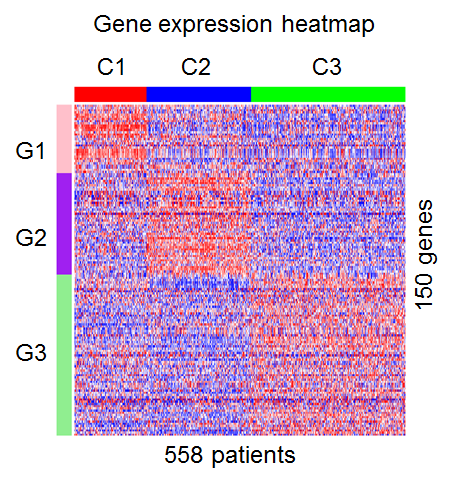


  1   2   3 
121 176 261 

 1  2  3 
31 46 73 


In [9]:
##-- Retrieve sample & gene clusters and add to clinical table
##-- retrieve the basis matrix and coef matrix 
expr.sub.nmf.w <- basis(expr.sub.nmf)
expr.sub.nmf.h <- coef(expr.sub.nmf)

##-- retrieve gene cluster
expr.sub.nmf.geneclr <- predict(expr.sub.nmf, 'features')
expr.sub.nmf.geneclr <- data.frame(gene = row.names(expr.sub.nmf.w), 
                                  cluster = expr.sub.nmf.geneclr)
row.names(expr.sub.nmf.geneclr) <- expr.sub.nmf.geneclr$gene
expr.sub.nmf.geneclr <- expr.sub.nmf.geneclr[
    order(expr.sub.nmf.geneclr$cluster),]

print('Gene clusters ... ')
print(table(expr.sub.nmf.geneclr$cluster))
print(expr.sub.nmf.geneclr[1:3,])

##-- retrieve sample cluster
expr.sub.nmf.smclr <- predict(expr.sub.nmf)
expr.sub.nmf.smclr <- data.frame(sample = colnames(expr.sub.nmf.h), 
                                cluster = expr.sub.nmf.smclr)
row.names(expr.sub.nmf.smclr) <- expr.sub.nmf.smclr$sample
expr.sub.nmf.smclr <- expr.sub.nmf.smclr[
    order(expr.sub.nmf.smclr$cluster),]

print('Sample clusters ... ')
print(table(expr.sub.nmf.smclr$cluster))
print(expr.sub.nmf.smclr[1:3,])

##-- add sample cluster to clinical table
clinical <- merge(clinical, expr.sub.nmf.smclr, by = 'sample')
clinical$cluster <- as.numeric(clinical$cluster)
clinical <- clinical[order(clinical$cluster),]
clinical$cluster <- as.character(clinical$cluster)

##-- Plot sample correlation and gene expression heatmaps
##-- prepare for plotting heatmaps
gene.counts <- data.frame(table(expr.sub.nmf.geneclr$cluster))
gene.colors <- c(rep('pink',gene.counts[1,2]),
                rep('purple',gene.counts[2,2]),
                rep('lightgreen',gene.counts[3,2]))
sample.counts <- data.frame(table(expr.sub.nmf.smclr$cluster))
sample.colors <- c(rep('red',sample.counts[1,2]),
                  rep('blue',sample.counts[2,2]),
                  rep('green',sample.counts[3,2]))

##-- calculate expression correlation between samples
expr.sub.srt <- expr.sub[,clinical$sample]
expr.sub.srt <- expr.sub.srt[row.names(expr.sub.srt) %in% 
                            expr.sub.nmf.geneclr$gene,]
expr.sub.srt <- expr.sub.srt[as.character(expr.sub.nmf.geneclr$gene),]
expr.sub.cor <- cor(expr.sub.srt)

##-- plot sample correlation heatmap
my.heatcol <- bluered(177) 
my.breaks <- sort(unique(c(seq(-1, -0.5, length.out=20),
                          seq(-0.5, 0.5, length.out=140),
                          seq(0.5, 1, length.out=20))))
centered <- t(scale(t(expr.sub.cor), scale=FALSE))
##-- skip in workshop!!
# png(file=paste0(out.dir,'/',expr.file,'.nmf.cor_heatmap.png'), width=800, height=800)
# heatmap <- heatmap.2(centered, 
#                     dendrogram='none', 
#                     Rowv=NULL,
#                     Colv=NULL,
#                     col=my.heatcol, 
#                     RowSideColors=sample.colors, 
#                     ColSideColors=sample.colors, 
#                     density.info='none', 
#                     trace='none', 
#                     key=TRUE, keysize=1.2, 
#                     labRow=FALSE,labCol=FALSE,
#                     xlab='Samples',ylab='Samples',
#                     main = 'Sample correlation heatmap')
# dev.off()

##-- plot gene expression heatmap
my.heatcol <- bluered(177) 
centered <- t(scale(t(expr.sub.srt), scale=FALSE)) 
##-- skip in workshop!!
# png(file=paste0(out.dir,'/',expr.file,'.nmf.gene_heatmap.png'), width=800, height=800)
# heatmap <- heatmap.2(centered, 
#                     dendrogram='none', 
#                     Rowv=NULL,
#                     Colv=NULL,
#                     col=my.heatcol, 
#                     RowSideColors=gene.colors, 
#                     ColSideColors=sample.colors, 
#                     density.info='none', 
#                     trace='none', 
#                     key=TRUE, keysize=1.2, 
#                     labRow=FALSE,labCol=FALSE,
#                     xlab='Samples',ylab='Genes',
#                     main = 'Gene expression heatmap')
# dev.off()

##-- directly view pre-generated heatmaps (workshop only)
display_png(file='ipynb_data/assets/Figure22.2.png')

print(table(expr.sub.nmf.smclr$cluster))
print(table(expr.sub.nmf.geneclr$cluster))

### 10. Survival analysis: KM plot and log-rank test<a class="anchor" id="04.10"></a> <small>[[top](#top)]</small>


DECEASED   LIVING 
     292      266 

[1] "========================================"

[1] "Running log-rank test for survival"


Call:
survdiff(formula = surv ~ clinical$cluster)

                     N Observed Expected (O-E)^2/E (O-E)^2/V
clinical$cluster=1 121       69     52.8      5.00      6.15
clinical$cluster=2 176       98     87.0      1.38      1.98
clinical$cluster=3 261      125    152.2      4.86     10.26

 Chisq= 11.4  on 2 degrees of freedom, p= 0.00341 

[1] "========================================"

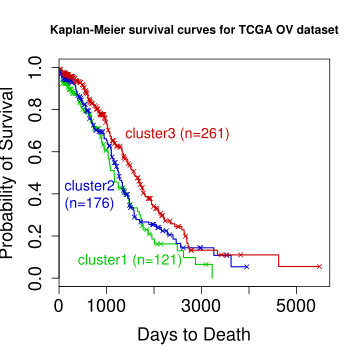

In [10]:
##-- Set up R plot display options in notebook
options(jupyter.plot_mimetypes = "image/svg+xml") 
options(repr.plot.width = 5, repr.plot.height = 5)

##-- add right censoring
table(clinical$vital.status)
clinical$censor <- NA
clinical$censor[which(clinical$vital.status == 'LIVING')] <- 0
clinical$censor[which(clinical$vital.status == 'DECEASED')] <- 1
clinical$censor <- as.numeric(clinical$censor)

##-- KM plot 
surv <- Surv(clinical$overall.survival.day, clinical$censor)
surv.fit <- survfit(surv ~ clinical$cluster)
plot(surv.fit, mark=4, col=c('#00CC00','#0000CC','#CC0000'), 
     lty=1, lwd=1.5,cex=0.8,cex.lab=1.5, cex.axis=1.5, cex.main=1,
     main='Kaplan-Meier survival curves for TCGA OV dataset',
     xlab='Days to Death', 
     ylab='Probability of Survival')
text(1500,0.08,  labels=paste0('cluster1 (n=',sample.counts[1,2],')'), 
     cex=1.2, col='#00CC00')
text(650,0.40, labels=paste0('cluster2\n(n=',sample.counts[2,2],')'), 
     cex=1.2, col='#0000CC')
text(2500,0.68, labels=paste0('cluster3 (n=',sample.counts[3,2],')'), 
     cex=1.2, col='#CC0000')

separator

##-- log-rank test
print(paste0('Running log-rank test for survival'))
surv <- Surv(clinical$overall.survival.day, clinical$censor)
surv.diff <- survdiff(surv ~ clinical$cluster)
surv.diff

separator

### 11. Survival analysis: Cox multi- and univariant model<a class="anchor" id="04.11"></a> <small>[[top](#top)]</small>

In [11]:
##-- cox pp haz model (comparing cluster 2 and 3 as an example!)
print(paste0('Running Cox proportional hazards model for survival'))
clinical.sub <- clinical[clinical$cluster %in% c(1,2,3),]
surv <- Surv(clinical.sub$overall.survival.day, 
            clinical.sub$censor)

print('Cluster 1 will be set as baseline ... ')

separator

##-- univariate cox model 
print(paste0('(a) Univariate cox model for survival'))
m1 <- coxph(surv~(clinical.sub$cluster))
tidy(m1)

separator

##-- full cox model
print(paste0('(b) Full multivariate cox model for survival'))
m2 <- coxph(surv~(clinical.sub$cluster + 
                 clinical.sub$age.at.diagnosis.year + 
                 clinical.sub$tumor.grade))
tidy(m2)

separator

##-- reduced cox model
##-- Always use the simplest model with the least necessary amount 
##-- of covariates to minimize overfitting
print(paste0('(c) Reduced multivariate cox model for survival'))
m3 <- coxph(surv~(clinical.sub$cluster + 
                 clinical.sub$age.at.diagnosis.year))
tidy(m3)

[1] "Running Cox proportional hazards model for survival"
[1] "Cluster 1 will be set as baseline ... "


[1] "========================================"

[1] "(a) Univariate cox model for survival"


term,estimate,std.error,statistic,p.value,conf.low,conf.high
clinical.sub$cluster2,-0.1511201,0.1575786,-0.9590139,0.337551720,-0.4599685,0.1577283
clinical.sub$cluster3,-0.4701560,0.1507902,-3.1179473,0.001821154,-0.7656994,-0.1746126


[1] "========================================"

[1] "(b) Full multivariate cox model for survival"


term,estimate,std.error,statistic,p.value,conf.low,conf.high
clinical.sub$cluster2,-0.17618871,0.159280488,-1.1061538,0.2686599769,-0.488372730,0.13599531
clinical.sub$cluster3,-0.49421043,0.152268438,-3.2456524,0.0011718180,-0.792651084,-0.19576977
clinical.sub$age.at.diagnosis.year,0.01939655,0.005375269,3.6084804,0.0003079958,0.008861218,0.02993188
clinical.sub$tumor.gradeG2,0.33717216,0.728847771,0.4626098,0.6436440486,-1.091343225,1.76568754
clinical.sub$tumor.gradeG3,0.66495465,0.715362320,0.9295355,0.3526116503,-0.737129730,2.06703904
clinical.sub$tumor.gradeG4,1.39327398,1.232324618,1.1306063,0.2582208349,-1.022037893,3.80858585
clinical.sub$tumor.gradeGB,0.72658417,1.233218512,0.5891771,0.5557424449,-1.690479703,3.14364804
clinical.sub$tumor.gradeGX,0.94706274,0.842082368,1.1246676,0.2607299261,-0.703388377,2.59751385


[1] "========================================"

[1] "(c) Reduced multivariate cox model for survival"


term,estimate,std.error,statistic,p.value,conf.low,conf.high
clinical.sub$cluster2,-0.12718686,0.157630939,-0.8068648,0.4197443559,-0.436137827,0.18176410
clinical.sub$cluster3,-0.44820549,0.150838184,-2.9714326,0.0029641397,-0.743842901,-0.15256808
clinical.sub$age.at.diagnosis.year,0.01974086,0.005344462,3.6937042,0.0002210109,0.009265909,0.03021582


## Associate gene expression with clincial outcome - End

### 12. Stop the clock!<a class="anchor" id="04.12"></a> <small>[[top](#top)]</small>

In [12]:
proc.time() - ptm

   user  system elapsed 
  4.763   0.388   5.148 

In [13]:
print('Program run finished!')

##-- Print analysis environment (for reproducible research)
sessionInfo()

[1] "Program run finished!"


R version 3.3.1 (2016-06-21)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 14.04.5 LTS

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] IRdisplay_0.4.9000  NMF_0.20.6          Biobase_2.32.0     
 [4] BiocGenerics_0.18.0 cluster_2.0.5       rngtools_1.2.4     
 [7] pkgmaker_0.22       registry_0.3        survival_2.39-5    
[10] gplots_3.0.1        broom_0.4.1         reshape_0.8.6      
[13] RColorBrewer_1.1-2  ggplot2_2.1.0      

loaded via a namespace (and not attached):
 [1] pbdZMQ_0.2-4       gtools_3.5.0       repr